In [52]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# --------------------------
# Configuration
# --------------------------
input_dir = "/Users/user/Event-data/Women/WEURO 2025/"
output_model_dir = "/Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/"
os.makedirs(output_model_dir, exist_ok=True)

all_summaries = []

# --------------------------
# Process Each CSV File
# --------------------------
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename)
        print(f"\n🔄 Processing: {filename}")

        # Load Data
        df = pd.read_csv(file_path)
        type_cols = [col for col in df.columns if '/qualifierId' in col]

        df['endX'] = np.nan
        df['endY'] = np.nan
        df['HighClaim'] = 0
        df['Catch'] = 0
        df['Punch'] = 0
        df['Caught'] = 0
        df['Collected'] = 0

        for i in range(len(df)):
            for j, col in enumerate(type_cols):
                qual_id = df.iloc[i][col]
                value_col = f'qualifier/{j}/value'
                if pd.isna(qual_id):
                    continue
                if qual_id == 140:
                    df.at[i, 'endX'] = df.at[i, value_col]
                elif qual_id == 141:
                    df.at[i, 'endY'] = df.at[i, value_col]
                elif qual_id == 11:
                    df.at[i, 'HighClaim'] = 1
                elif qual_id in [92, 93]:
                    df.at[i, 'Catch'] = 1
                elif qual_id == 128:
                    df.at[i, 'Punch'] = 1
                elif qual_id == 176:
                    df.at[i, 'Caught'] = 1
                elif qual_id == 177:
                    df.at[i, 'Collected'] = 1

        # Success Label
        df['successful'] = df['outcome'].apply(lambda x: 1 if x == 1 else 0)
        df = df.dropna(subset=['x', 'y'])

        df['distanceToGoal'] = np.sqrt((df['x'])**2 + (df['y'] - 50)**2)
        df['angleToGoal'] = np.degrees(np.arctan2(abs(df['y'] - 50), df['x'].replace(0, 0.001)))

        for col in ['HighClaim', 'Catch', 'Punch', 'Caught', 'Collected']:
            df[col] *= 3

        features = ['distanceToGoal', 'angleToGoal', 'HighClaim', 'Catch', 'Punch', 'Caught', 'Collected']
        X = df[features].fillna(0).astype(float)
        y = df['successful']

        # Train/Test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.1,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )
        model.fit(X_train, y_train)

        # Predict
        df['predicted_success_prob'] = model.predict_proba(X)[:, 1]

        # Export relevant columns
        export_cols = ['playerName', 'contestantId', 'distanceToGoal', 'angleToGoal',
                       'HighClaim', 'Catch', 'Punch', 'Caught', 'Collected',
                       'successful', 'predicted_success_prob']
        df_export = df[export_cols].copy()

        base_name = os.path.splitext(filename)[0]
        output_excel = os.path.join(output_model_dir, f"{base_name} - GK Model Output.xlsx")
        df_export.to_excel(output_excel, index=False)

        # Detect GK
        gk_type_ids = [52, 53, 54]
        gks = df[df['typeId'].isin(gk_type_ids)]['playerName'].dropna().unique().tolist()
        df_export_gk = df_export[df_export['playerName'].isin(gks)]

        # GK Summary
        if not df_export_gk.empty:
            summary = df_export_gk.groupby('playerName').agg(
                total_actions=('successful', 'count'),
                successful_actions=('successful', 'sum'),
                average_success_score=('predicted_success_prob', 'mean'),
                expected_successes=('predicted_success_prob', 'sum')
            )
            summary['actual_success_rate'] = summary['successful_actions'] / summary['total_actions']
            summary = summary.round(3)
            summary['match'] = base_name
            all_summaries.append(summary)

            summary_output = os.path.join(output_model_dir, f"{base_name} - GK Summary.xlsx")
            summary.to_excel(summary_output)
            print(f"✅ Saved: {summary_output}")
        else:
            print(f"⚠️ No GK actions found in {filename}")

# --------------------------
# Save Combined Summary
# --------------------------
if all_summaries:
    combined_summary = pd.concat(all_summaries)
    combined_summary.to_excel(os.path.join(output_model_dir, "Combined_GK_Summary.xlsx"))
    print("📊 Combined summary saved.")



🔄 Processing: France 4-1 Wales.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '33.7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.3' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:07:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/France 4-1 Wales - GK Summary.xlsx

🔄 Processing: Italy 1-3 Spain.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '36.7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:07:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Italy 1-3 Spain - GK Summary.xlsx

🔄 Processing: Poland 3-2 Denmark.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '47.9' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '34.4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:07:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Poland 3-2 Denmark - GK Summary.xlsx

🔄 Processing: Norway 4-3 Iceland.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '40.6' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '30.2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:07:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Norway 4-3 Iceland - GK Summary.xlsx

🔄 Processing: Spain 5-0 Portugal.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '53.7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '35.8' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:07:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Spain 5-0 Portugal - GK Summary.xlsx

🔄 Processing: Spain 6-2 Belgium.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '33.8' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '47.6' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:07:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Spain 6-2 Belgium - GK Summary.xlsx

🔄 Processing: Iceland 0-1 Finland.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '34.2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:07:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Iceland 0-1 Finland - GK Summary.xlsx

🔄 Processing: Wales 0-3 Netherlands.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '47.8' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '35.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:07:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Wales 0-3 Netherlands - GK Summary.xlsx

🔄 Processing: Denmark 0-1 Sweden.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51.9' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '30.5' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:07:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Denmark 0-1 Sweden - GK Summary.xlsx

🔄 Processing: England 4-0 Netherlands.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '29.6' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '56.7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:08:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/England 4-0 Netherlands - GK Summary.xlsx

🔄 Processing: Germany 2-0 Poland.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '59.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '36.7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:08:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Germany 2-0 Poland - GK Summary.xlsx

🔄 Processing: Finland 1-1 Switzerland.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32.3' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '65.5' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:08:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Finland 1-1 Switzerland - GK Summary.xlsx

🔄 Processing: Portugal 1-2 Belgium.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '36.1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '53.7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:08:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Portugal 1-2 Belgium - GK Summary.xlsx

🔄 Processing: Switzerland 1-2 Norway.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '38.1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:08:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Switzerland 1-2 Norway - GK Summary.xlsx

🔄 Processing: France 2-1 England.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '23.5' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:08:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/France 2-1 England - GK Summary.xlsx

🔄 Processing: Switzerland 2-0 Iceland.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '34.2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '39.2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:08:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Switzerland 2-0 Iceland - GK Summary.xlsx

🔄 Processing: Poland 0-3 Sweden.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '29.5' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '54.8' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:08:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Poland 0-3 Sweden - GK Summary.xlsx

🔄 Processing: Portugal 1-1 Italy.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '36.2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51.4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:08:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Portugal 1-1 Italy - GK Summary.xlsx

🔄 Processing: Netherlands 2-5 France.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '68.4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32.4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:08:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Netherlands 2-5 France - GK Summary.xlsx

🔄 Processing: Sweden 4-1 Germany.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '35.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '45.8' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:08:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Sweden 4-1 Germany - GK Summary.xlsx

🔄 Processing: England 6-1 Wales.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '23.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '54.3' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:08:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/England 6-1 Wales - GK Summary.xlsx

🔄 Processing: Belgium 0-1 Italy.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '57.3' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '35.8' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:09:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Belgium 0-1 Italy - GK Summary.xlsx

🔄 Processing: Norway 2-1 Finland.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.3' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '34.2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:09:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Norway 2-1 Finland - GK Summary.xlsx

🔄 Processing: Germany 2-1 Denmark.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '44.8' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_4146/232747275.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '33.1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:09:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Saved: /Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Germany 2-1 Denmark - GK Summary.xlsx
📊 Combined summary saved.


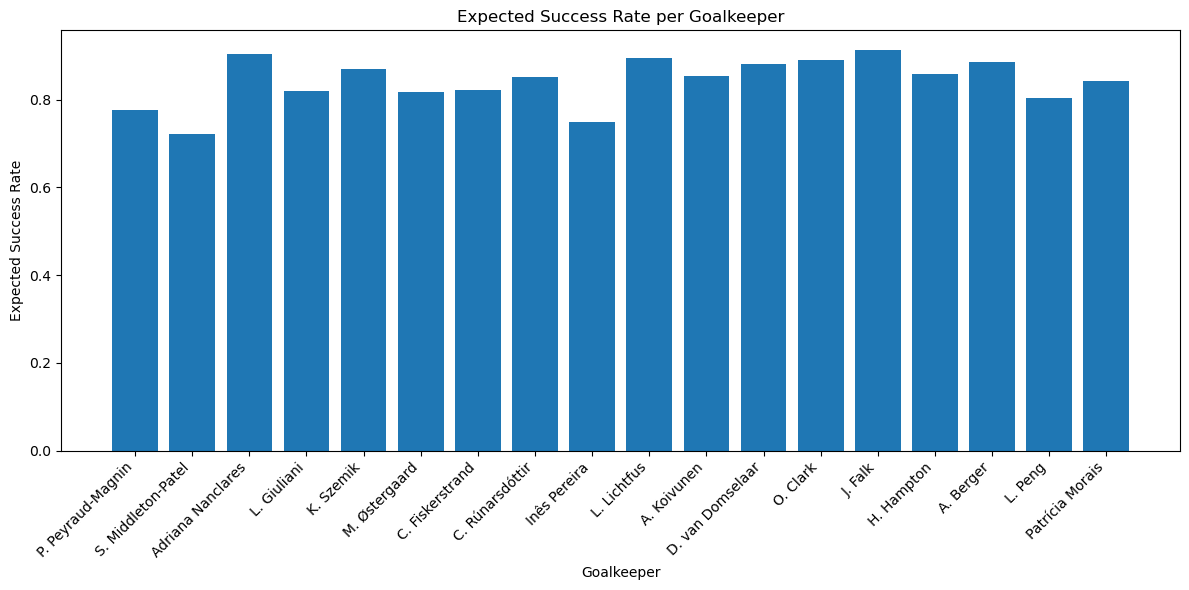

In [53]:
import matplotlib.pyplot as plt

# Compute expected success rate
combined_summary['expected_success_rate'] = combined_summary['expected_successes'] / combined_summary['total_actions']

# Reset index to access playerName as a column
summary_plot = combined_summary.reset_index()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(summary_plot['playerName'], summary_plot['expected_success_rate'])
plt.xlabel('Goalkeeper')
plt.ylabel('Expected Success Rate')
plt.title('Expected Success Rate per Goalkeeper')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


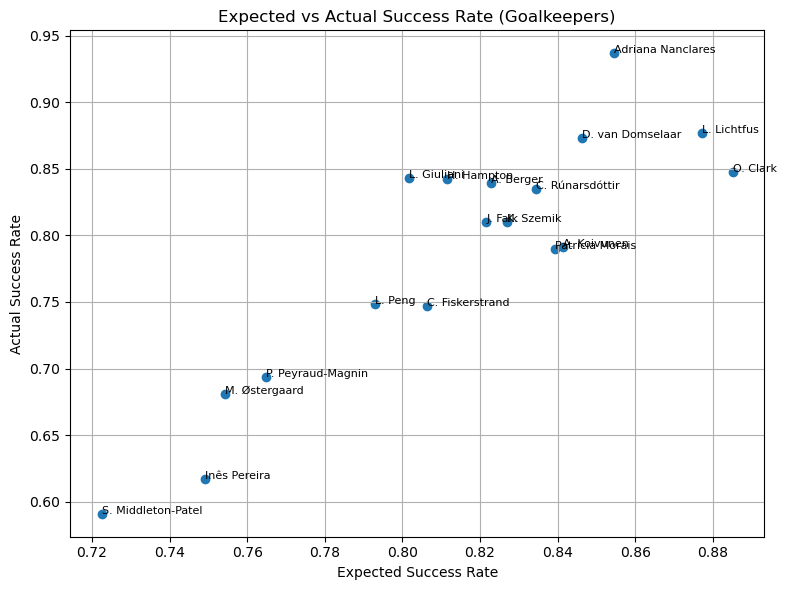

In [55]:
# Group by playerName and average across matches
unique_summary = summary_plot.groupby('playerName', as_index=False).agg({
    'expected_success_rate': 'mean',
    'actual_success_rate': 'mean'
})

# Scatter plot: Expected vs Actual Success Rate
plt.figure(figsize=(8, 6))
plt.scatter(
    unique_summary['expected_success_rate'],
    unique_summary['actual_success_rate']
)

# Add labels
for i, row in unique_summary.iterrows():
    plt.text(row['expected_success_rate'], row['actual_success_rate'], row['playerName'], fontsize=8)

plt.xlabel('Expected Success Rate')
plt.ylabel('Actual Success Rate')
plt.title('Expected vs Actual Success Rate (Goalkeepers)')
plt.grid(True)
plt.tight_layout()
plt.show()



🔄 Processing: France 4-1 Wales.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '33.7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.3' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]



🔄 Processing: Italy 1-3 Spain.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '36.7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]



🔄 Processing: Poland 3-2 Denmark.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '47.9' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '34.4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]



🔄 Processing: Norway 4-3 Iceland.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '40.6' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '30.2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]



🔄 Processing: Spain 5-0 Portugal.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '53.7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '35.8' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]



🔄 Processing: Spain 6-2 Belgium.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '33.8' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '47.6' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]



🔄 Processing: Iceland 0-1 Finland.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '34.2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]



🔄 Processing: Wales 0-3 Netherlands.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '47.8' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '35.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]



🔄 Processing: Denmark 0-1 Sweden.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51.9' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '30.5' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]



🔄 Processing: England 4-0 Netherlands.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '29.6' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '56.7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]



🔄 Processing: Germany 2-0 Poland.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '59.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '36.7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]



🔄 Processing: Finland 1-1 Switzerland.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32.3' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '65.5' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]



🔄 Processing: Portugal 1-2 Belgium.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '36.1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '53.7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]



🔄 Processing: Switzerland 1-2 Norway.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '38.1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]



🔄 Processing: France 2-1 England.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '23.5' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]



🔄 Processing: Switzerland 2-0 Iceland.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '34.2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '39.2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]



🔄 Processing: Poland 0-3 Sweden.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '29.5' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '54.8' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]



🔄 Processing: Portugal 1-1 Italy.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '36.2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51.4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]



🔄 Processing: Netherlands 2-5 France.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '68.4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32.4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]



🔄 Processing: Sweden 4-1 Germany.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '35.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '45.8' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]



🔄 Processing: England 6-1 Wales.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '23.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '54.3' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]



🔄 Processing: Belgium 0-1 Italy.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '57.3' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '35.8' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]



🔄 Processing: Norway 2-1 Finland.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.3' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '34.2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]



🔄 Processing: Germany 2-1 Denmark.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '44.8' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df.at[i, value_col]
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_8752/2099737497.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '33.1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df.at[i, value_col]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:33:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/t

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.10      0.18      2062
           1       0.76      0.98      0.86      5963

    accuracy                           0.76      8025
   macro avg       0.72      0.54      0.52      8025
weighted avg       0.74      0.76      0.68      8025

🔍 Accuracy: 0.7567601246105919
📈 AUC: 0.667928380851006


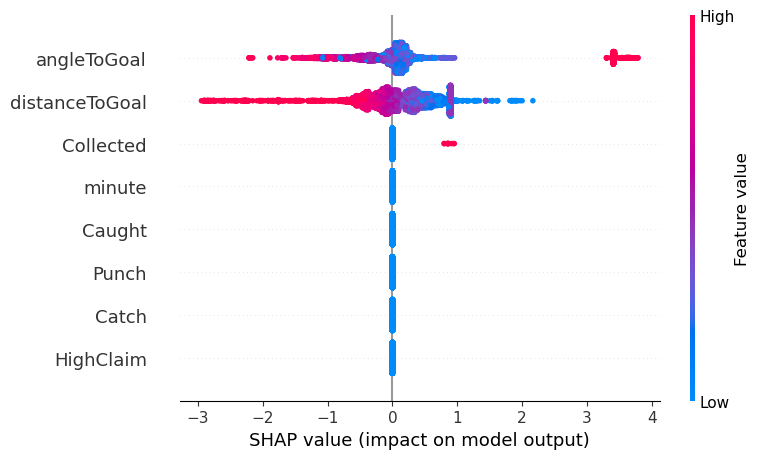

<Figure size 640x480 with 0 Axes>


📊 Combined GK Summary saved to:
/Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/Combined_GK_Summary.xlsx


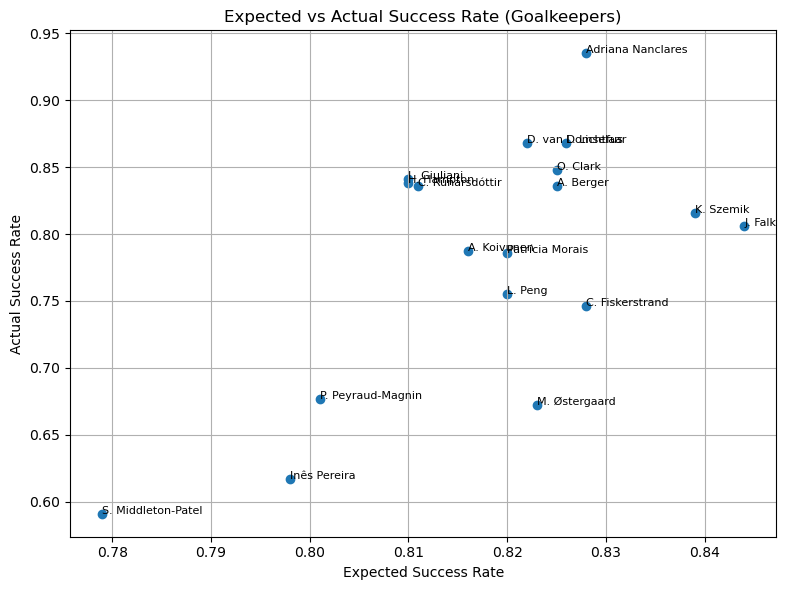

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import shap

# --------------------------
# Configuration
# --------------------------
input_dir = "/Users/user/Event-data/Women/WEURO 2025/"
output_model_dir = "/Users/user/Event-data/Women/WEURO 2025/GK_Model_Outputs/"
os.makedirs(output_model_dir, exist_ok=True)

all_data = []
skipped_files = []

# --------------------------
# Load and Process Each CSV
# --------------------------
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename)
        print(f"\n🔄 Processing: {filename}")
        df = pd.read_csv(file_path)

        if not {'x', 'y', 'outcome'}.issubset(df.columns):
            print(f"⚠️ Skipping {filename} — missing required columns.")
            skipped_files.append(filename)
            continue

        type_cols = [col for col in df.columns if '/qualifierId' in col]
        df['endX'] = np.nan
        df['endY'] = np.nan
        df['HighClaim'] = 0
        df['Catch'] = 0
        df['Punch'] = 0
        df['Caught'] = 0
        df['Collected'] = 0

        for i in range(len(df)):
            for j, col in enumerate(type_cols):
                qual_id = df.iloc[i][col]
                value_col = f'qualifier/{j}/value'
                if pd.isna(qual_id):
                    continue
                if qual_id == 140:
                    df.at[i, 'endX'] = df.at[i, value_col]
                elif qual_id == 141:
                    df.at[i, 'endY'] = df.at[i, value_col]
                elif qual_id == 11:
                    df.at[i, 'HighClaim'] = 1
                elif qual_id in [92, 93]:
                    df.at[i, 'Catch'] = 1
                elif qual_id == 128:
                    df.at[i, 'Punch'] = 1
                elif qual_id == 176:
                    df.at[i, 'Caught'] = 1
                elif qual_id == 177:
                    df.at[i, 'Collected'] = 1

        df = df.dropna(subset=['x', 'y'])
        if df.empty:
            skipped_files.append(filename)
            continue

        df['successful'] = df['outcome'].apply(lambda x: 1 if x == 1 else 0)
        df['distanceToGoal'] = np.sqrt((df['x'])**2 + (df['y'] - 50)**2)
        df['angleToGoal'] = np.degrees(np.arctan2(abs(df['y'] - 50), df['x'].replace(0, 0.001)))

        for col in ['HighClaim', 'Catch', 'Punch', 'Caught', 'Collected']:
            df[col] *= 3

        if 'timeSeconds' in df.columns:
            df['minute'] = df['timeSeconds'] // 60
        else:
            df['minute'] = np.nan

        df['match'] = os.path.splitext(filename)[0]
        all_data.append(df)

# --------------------------
# Combine All Matches
# --------------------------
if not all_data:
    raise ValueError("❌ No valid data found.")

df_all = pd.concat(all_data)
df_all = df_all.dropna(subset=['successful'])

# --------------------------
# Feature Engineering
# --------------------------
features = ['distanceToGoal', 'angleToGoal', 'HighClaim', 'Catch', 'Punch', 'Caught', 'Collected', 'minute']
X = df_all[features].fillna(0).astype(float)
y = df_all['successful']

# --------------------------
# Train/Test Split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# --------------------------
# Model Tuning and Training
# --------------------------
param_grid = {
    'max_depth': [4, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
}

grid = GridSearchCV(
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid,
    cv=3,
    verbose=0
)
grid.fit(X_train, y_train)
model = grid.best_estimator_

# --------------------------
# Evaluation
# --------------------------
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print("✅ Classification Report:\n", classification_report(y_test, y_pred))
print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("📈 AUC:", roc_auc_score(y_test, y_proba))

# --------------------------
# SHAP (TreeExplainer only)
# --------------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
plt.tight_layout()
plt.show()

# --------------------------
# Predict Probabilities for Full Dataset
# --------------------------
df_all['predicted_success_prob'] = model.predict_proba(X)[:, 1]

# --------------------------
# GK Summary Stats
# --------------------------
gk_type_ids = [52, 53, 54]
gks = df_all[df_all['typeId'].isin(gk_type_ids)]['playerName'].dropna().unique().tolist()
df_gk = df_all[df_all['playerName'].isin(gks)]

summary = df_gk.groupby('playerName').agg(
    total_actions=('successful', 'count'),
    successful_actions=('successful', 'sum'),
    expected_successes=('predicted_success_prob', 'sum'),
    average_success_score=('predicted_success_prob', 'mean')
)
summary['actual_success_rate'] = summary['successful_actions'] / summary['total_actions']
summary['expected_success_rate'] = summary['expected_successes'] / summary['total_actions']
summary['overperformance'] = summary['actual_success_rate'] - summary['expected_success_rate']
summary = summary.round(3)

# --------------------------
# Save Combined Summary
# --------------------------
summary_path = os.path.join(output_model_dir, "Combined_GK_Summary.xlsx")
summary.to_excel(summary_path)
print(f"\n📊 Combined GK Summary saved to:\n{summary_path}")

# --------------------------
# Scatter Plot: Expected vs Actual
# --------------------------
plt.figure(figsize=(8, 6))
plt.scatter(summary['expected_success_rate'], summary['actual_success_rate'])
for i, row in summary.reset_index().iterrows():
    plt.text(row['expected_success_rate'], row['actual_success_rate'], row['playerName'], fontsize=8)
plt.xlabel('Expected Success Rate')
plt.ylabel('Actual Success Rate')
plt.title('Expected vs Actual Success Rate (Goalkeepers)')
plt.grid(True)
plt.tight_layout()
plt.show()


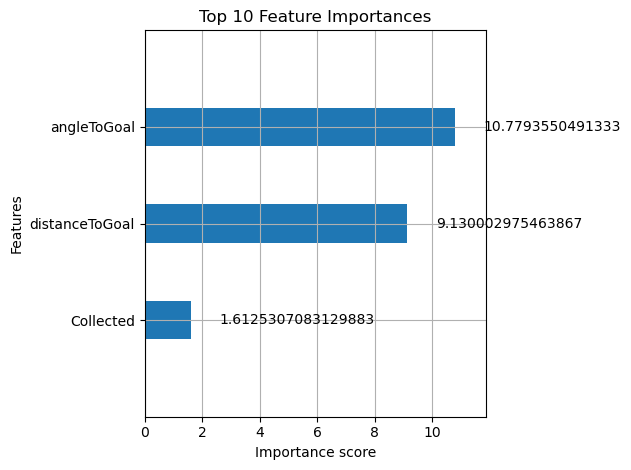

In [2]:
xgb.plot_importance(model, importance_type='gain', height=0.4, max_num_features=10, title='Top 10 Feature Importances')
plt.tight_layout()
plt.show()


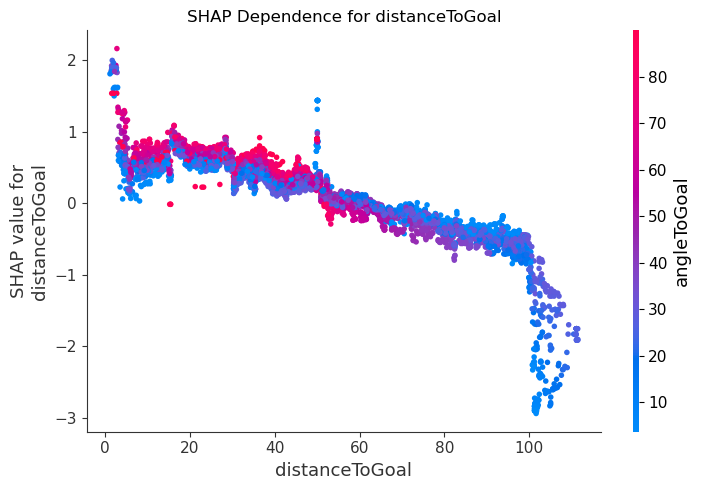

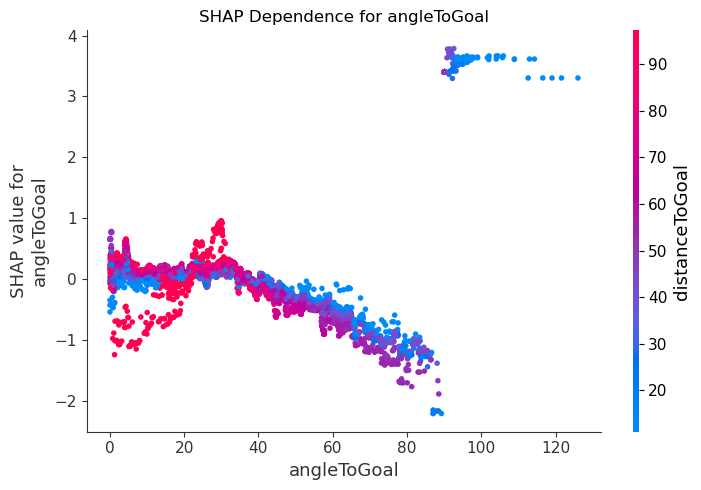

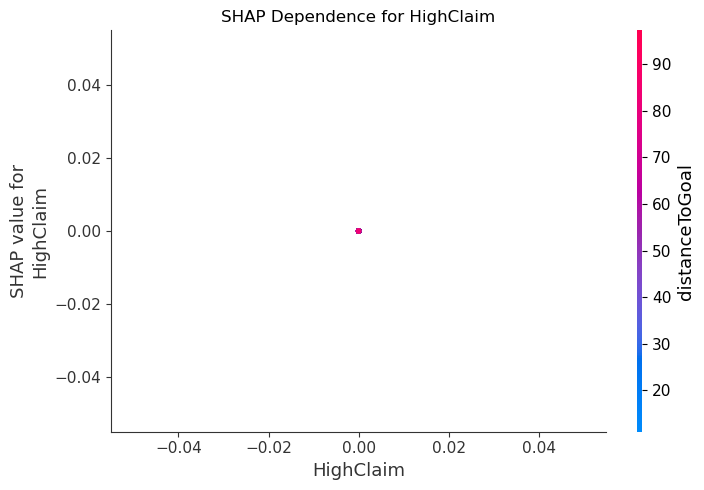

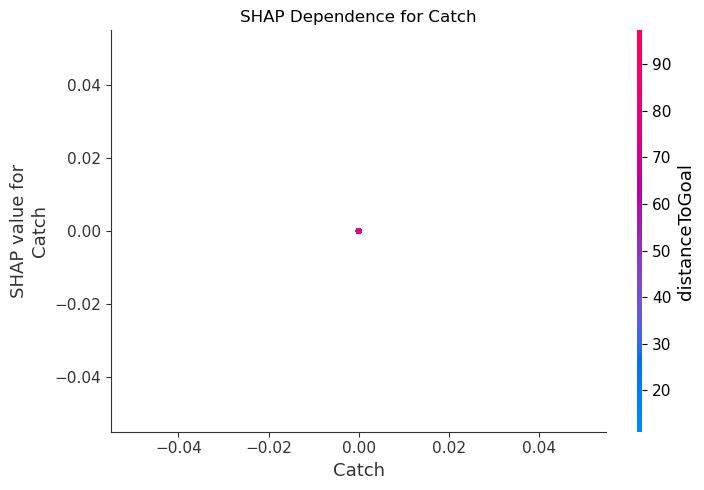

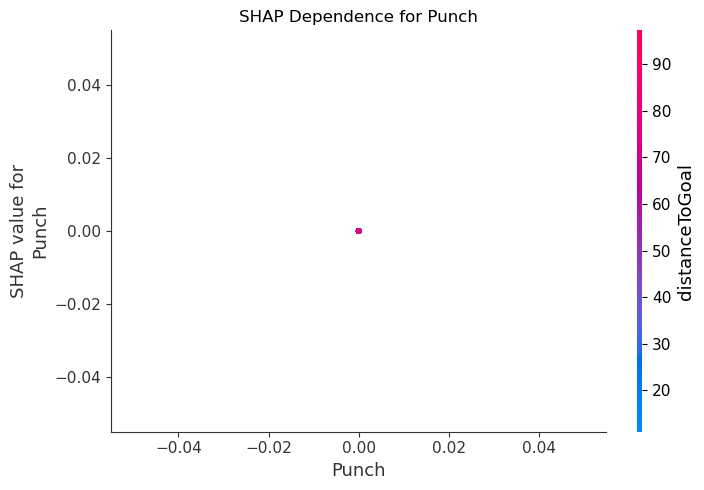

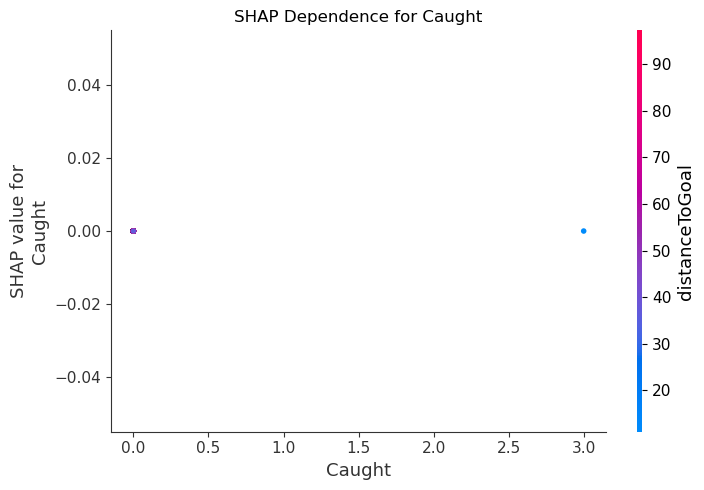

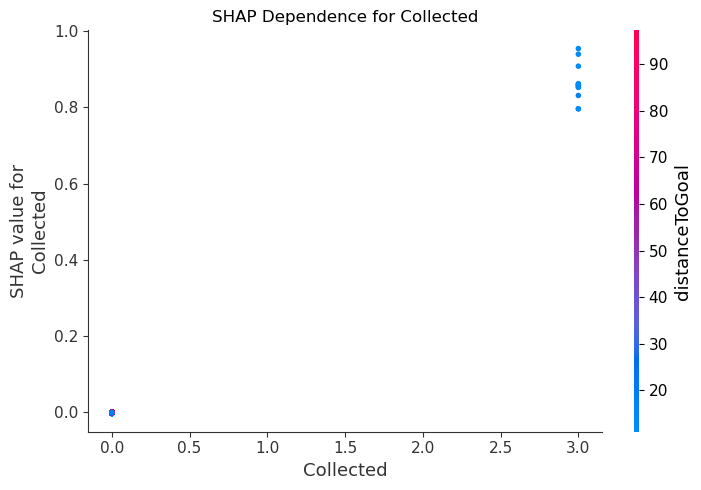

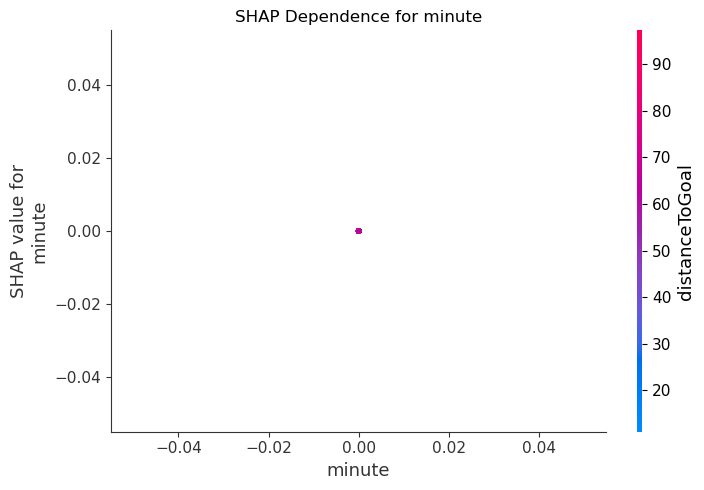

In [3]:
for feature in X.columns:
    shap.dependence_plot(feature, shap_values, X_test, show=False)
    plt.title(f'SHAP Dependence for {feature}')
    plt.tight_layout()
    plt.show()


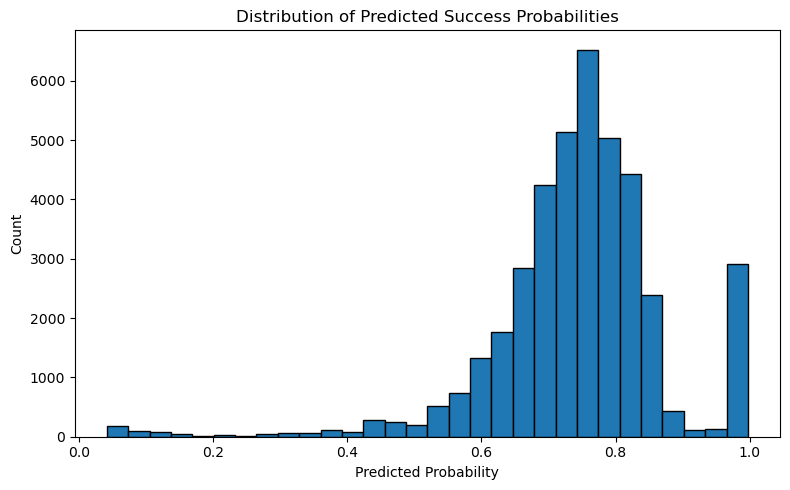

In [4]:
plt.figure(figsize=(8, 5))
plt.hist(df_all['predicted_success_prob'], bins=30, edgecolor='black')
plt.title("Distribution of Predicted Success Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


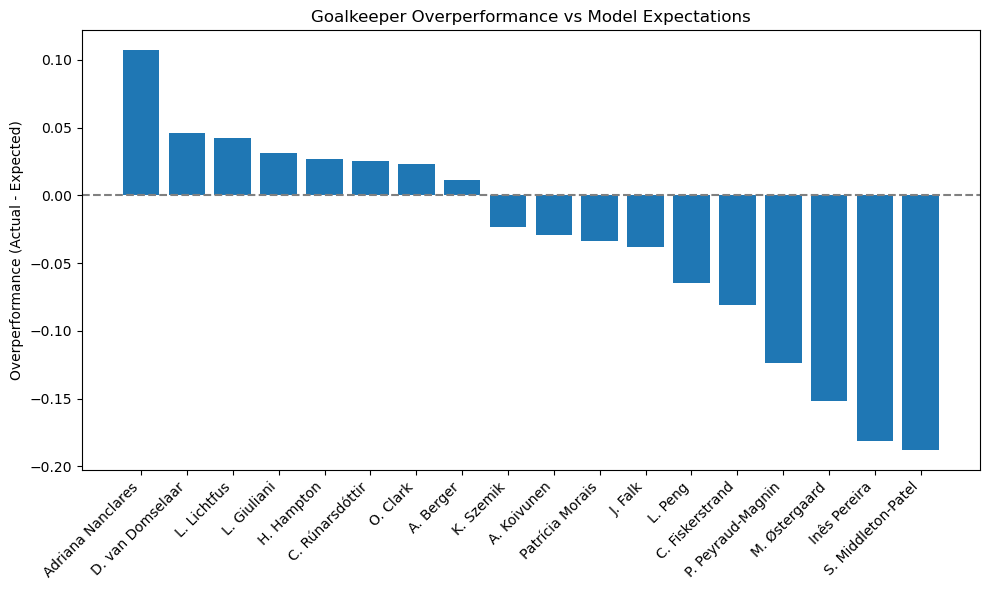

In [5]:
summary_sorted = summary.sort_values('overperformance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(summary_sorted.index, summary_sorted['overperformance'])
plt.axhline(0, color='gray', linestyle='--')
plt.title('Goalkeeper Overperformance vs Model Expectations')
plt.ylabel('Overperformance (Actual - Expected)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


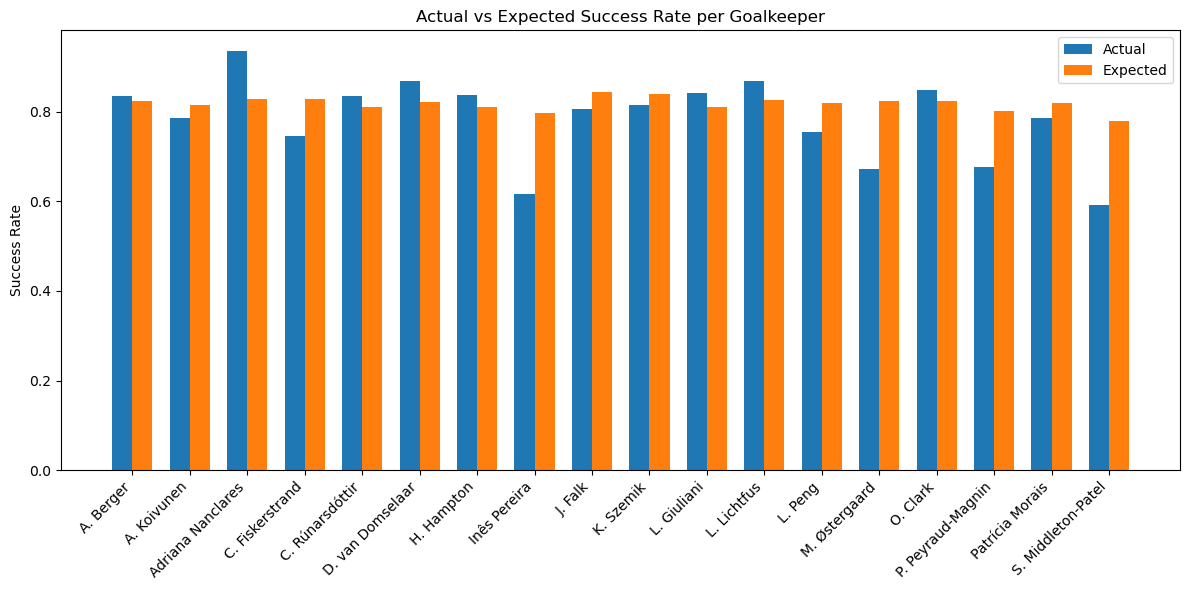

In [6]:
x = np.arange(len(summary))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, summary['actual_success_rate'], width, label='Actual')
plt.bar(x + width/2, summary['expected_success_rate'], width, label='Expected')

plt.xticks(x, summary.index, rotation=45, ha='right')
plt.ylabel('Success Rate')
plt.title('Actual vs Expected Success Rate per Goalkeeper')
plt.legend()
plt.tight_layout()
plt.show()


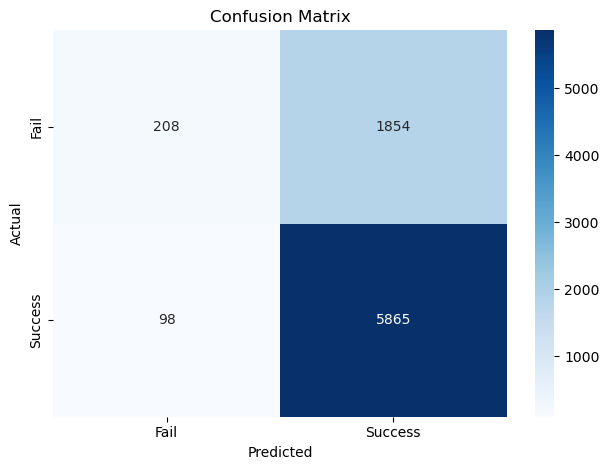

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fail', 'Success'], yticklabels=['Fail', 'Success'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
